In [1]:
import copy
import os
import numpy as np
import random
import time
import copy
from operator import attrgetter

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from enum import Enum
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# If AMD GPU, comment if not needed
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Dropout
from keras.models import Sequential
# If not AMD GPU change keras.optimizers to tensorflow.keras.optimizers
# from tensorflow.keras.optimizers import SGD, Adam
from keras.optimizers import SGD, Adam

Using plaidml.keras.backend backend.


# Configuration

In [2]:
class ActivationType(Enum):
  relu = 'relu'
  softmax = 'softmax'     
  elu = 'elu'  

In [3]:
class PoolingTypes(Enum):
  avg_pooling = 1
  max_pooling = 2

In [4]:
class OptimizerType(Enum):
  adam = 1
  sgd = 2

In [5]:
class Configuration:
  kernel_size_set = range(1, 10, 2)
  act_set = [ActivationType.relu, ActivationType.softmax]
  pooling_set = [PoolingTypes.max_pooling, PoolingTypes.avg_pooling]
  neuron_set = range(1, 300)
  epochs_set = range(1, 20)  
  batch_size_set = [16, 32, 64]
  optimizer_set = [OptimizerType.adam, OptimizerType.sgd]

  def __init__(self, convulution_kernel_size = 3, 
               convulution_act = ActivationType.relu, 
               pooling_layer_type = PoolingTypes.max_pooling, 
               pooling_layer_kernel_size = 2, 
               first_dense_layer_neurons = 256, 
               first_dense_act = ActivationType.relu, 
               second_dense_act = ActivationType.softmax, 
               include_first_droput_layer = False,
               first_dropout_rate = 0.5, 
               include_second_droput_layer = True,
               second_dropout_rate = 0.5, 
               optimizer_type = OptimizerType.sgd, 
               learning_rate = 0.01,
               epochs = 15, 
               batch_size = 32) -> None:
    self.convulution_kernel_size = convulution_kernel_size
    self.convulution_act = convulution_act
    self.pooling_layer_type = pooling_layer_type
    self.pooling_layer_kernel_size = pooling_layer_kernel_size
    self.first_dense_layer_neurons = first_dense_layer_neurons
    self.first_dense_act = first_dense_act    
    self.second_dense_act = second_dense_act
    self.include_first_droput_layer = include_first_droput_layer
    self.first_dropout_rate = first_dropout_rate
    self.include_second_droput_layer = include_second_droput_layer
    self.second_dropout_rate = second_dropout_rate
    self.optimizer_type = optimizer_type
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.batch_size = batch_size
    self.loss = None
    self.fitness = 0

In [6]:
def create_random():
  first_dense_neurons = random.choice(Configuration.neuron_set)
  second_dense_neurons = random.choice(range(min(Configuration.neuron_set), first_dense_neurons))
  return Configuration(
      random.choice(Configuration.kernel_size_set),
      random.choice(Configuration.act_set),
      random.choice(Configuration.pooling_set),
      random.choice(Configuration.kernel_size_set),
      first_dense_neurons,
      random.choice(Configuration.act_set),
      random.choice(Configuration.act_set),
      bool(random.getrandbits(1)),
      random.uniform(0, 1),
      bool(random.getrandbits(1)),
      random.uniform(0, 1),
      random.choice(Configuration.optimizer_set),
      random.uniform(0.0001, 0.2),
      random.choice(Configuration.epochs_set),
      random.choice(Configuration.batch_size_set)
  )

# CNN

In [7]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.savefig("demo_train.png")

In [8]:
def cnn(config, img_train, img_test, label_train, label_test):
  if config.loss is not None:
    return config.loss

  model = Sequential()

  model.add(Conv2D(32, (config.convulution_kernel_size, config.convulution_kernel_size), activation=config.convulution_act.value, input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (config.convulution_kernel_size, config.convulution_kernel_size), activation=config.convulution_act.value))

  if config.pooling_layer_type == PoolingTypes.max_pooling:
    model.add(MaxPooling2D(pool_size=(config.pooling_layer_kernel_size, config.pooling_layer_kernel_size)))
  elif config.pooling_layer_type == PoolingTypes.avg_pooling:
    model.add(AveragePooling2D(pool_size = (config.pooling_layer_kernel_size, config.pooling_layer_kernel_size)))
  if config.include_first_droput_layer:
    model.add(Dropout(config.first_dropout_rate))

  model.add(Flatten())
  model.add(Dense(config.first_dense_layer_neurons, activation=config.first_dense_act.value))
  if config.include_second_droput_layer:
    model.add(Dropout(config.second_dropout_rate))

  model.add(Dense(10, activation=config.second_dense_act.value)) # ennek softmaxnak kell lennie

  if config.optimizer_type == OptimizerType.sgd:
    opt = SGD(lr=config.learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
  elif config.optimizer_type == OptimizerType.adam:
    opt = Adam(lr=config.learning_rate)

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
  history = model.fit(img_train,label_train, epochs=config.epochs, batch_size=config.batch_size, verbose=2, validation_split=0.0)

  return model.evaluate(img_test, label_test)[0]


In [9]:
(img_train, label_train), (img_test, label_test) = cifar10.load_data()
label_train = to_categorical(label_train, num_classes=10)
label_test = to_categorical(label_test, num_classes=10)
img_train = img_train.astype('float32')
img_test = img_test.astype('float32')
img_train /= 255
img_test /= 255

Epoch 1/18
 - 22s - loss: 1.7853 - acc: 0.3473
Epoch 2/18
 - 14s - loss: 1.4644 - acc: 0.4711
Epoch 3/18
 - 14s - loss: 1.3169 - acc: 0.5268
Epoch 4/18
 - 14s - loss: 1.2133 - acc: 0.5638
Epoch 5/18
 - 14s - loss: 1.1495 - acc: 0.5923
Epoch 6/18
 - 14s - loss: 1.0968 - acc: 0.6081
Epoch 7/18
 - 14s - loss: 1.0593 - acc: 0.6257
Epoch 8/18
 - 14s - loss: 1.0240 - acc: 0.6381
Epoch 9/18
 - 14s - loss: 1.0065 - acc: 0.6452
Epoch 10/18
 - 14s - loss: 0.9711 - acc: 0.6579
Epoch 11/18
 - 14s - loss: 0.9516 - acc: 0.6620
Epoch 12/18
 - 14s - loss: 0.9352 - acc: 0.6698
Epoch 13/18
 - 14s - loss: 0.9166 - acc: 0.6783
Epoch 14/18
 - 14s - loss: 0.9039 - acc: 0.6815
Epoch 15/18
 - 14s - loss: 0.8865 - acc: 0.6869
Epoch 16/18
 - 14s - loss: 0.8752 - acc: 0.6898
Epoch 17/18
 - 14s - loss: 0.8641 - acc: 0.6949
Epoch 18/18
 - 14s - loss: 0.8534 - acc: 0.6978


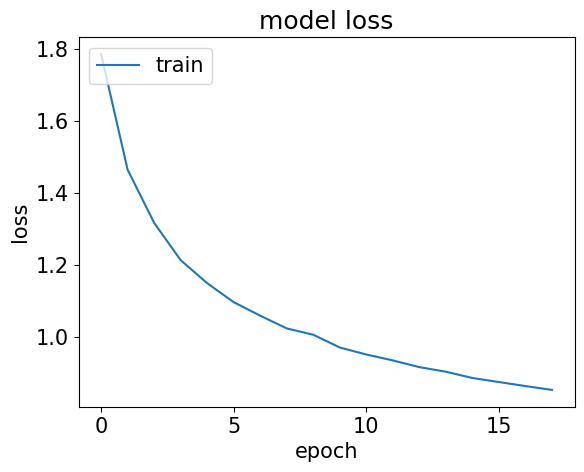

10000/10000 [==============================] - 4s 436us/step
[0.8255380259513855, 0.7191]


<Figure size 640x480 with 0 Axes>

In [67]:
config = Configuration(3, ActivationType.relu, PoolingTypes.avg_pooling, 7, 231, ActivationType.relu, ActivationType.softmax, True, 0.4556783710964882, False, 0.5, OptimizerType.sgd, 0.0335575973334044, 18, 64) #best i found
res = cnn(config, img_train, img_test, label_train, label_test)

print(res)

# Genetic Algorithm

In [10]:
class GA_parameters:
  max_population_size = 50
  min_population_size = 6
  population_size = 20
  max_number_of_generations = 50
  min_number_of_generations = 10
  number_of_generations = 25
  mutation_rate = 0.3
  min_mutation_rate = 0.0
  crossover_rate = 0.8
  min_crossover_rate = 0.1
  parameters_number = 15
  elite_rate = 0.1

In [11]:
def fitness(population):
  loss_values = np.empty((len(population), 2), float)
  
  fitness_values = [0 for _ in range(len(population))]
  for j in range(len(population)):
    loss_values[j][0] = j
    loss_values[j][1] = population[j].loss

  loss_sorted = loss_values[loss_values[:, 1].argsort()]

  sp = 2
  for j in range(len(population), 0, -1):
    fitness = 2-sp + 2 * (sp - 1) * (j - 1) / (len(population) - 1)
    fitness_values[int(loss_sorted[len(population)-j][0])] = fitness
    population[int(loss_sorted[len(population)-j][0])].fitness = fitness

  return fitness_values

In [12]:
def select_parents(fitness_values, population):
  selected_parent_idx = [0 for _ in range(GA_parameters.population_size)]
  fitness_tuples = [(i, fitness_values[i]) for i in range(GA_parameters.population_size)]
  sorted_fitnesses = sorted(fitness_tuples, key=lambda tup: tup[1])
  print(sorted_fitnesses)
  print(sorted_fitnesses)
  fitness_sum = sum(fitness_values)
  distance = fitness_sum / GA_parameters.population_size
  shift = random.uniform(0, distance)

  borders = [0 for _ in range(GA_parameters.population_size)]

  for i in range(GA_parameters.population_size):
    new_border = shift + i * distance
    borders[i] = new_border

  for border_id in range(len(borders)):
    i = 0
    roulette_sum = sorted_fitnesses[i][1]
    while roulette_sum < borders[border_id]:
      i = i + 1
      roulette_sum = roulette_sum + sorted_fitnesses[i][1]

    selected_parent_idx[border_id] = sorted_fitnesses[i][0]

  return selected_parent_idx

In [13]:
def crossover_blend(p1, p2, round_value):
    c1 = p1
    c2 = p2

    r = random.uniform(0, 1)
    c1 = p1 + r * (p2 - p1)
    c2 = p2 - r * (p2 - p1)

    if round_value:
      c1 = round(c1)
      c2 = round(c2)

    return c1, c2


In [14]:
def crossover_operation(p1, p2):
    prob = 0.5
    c1 = copy.deepcopy(p1)
    c2 = copy.deepcopy(p2)

    if random.uniform(0,1) < prob:
      c1.convulution_kernel_size, c2.convulution_kernel_size = crossover_blend(p1.convulution_kernel_size, p2.convulution_kernel_size, True)
    if random.uniform(0,1) < prob:
      c1.convulution_act, c2.convulution_act = p2.convulution_act, p1.convulution_act
    if random.uniform(0,1) < prob:
      c1.pooling_layer_type, c2.pooling_layer_type = p2.pooling_layer_type, p1.pooling_layer_type
    if random.uniform(0,1) < prob:
      c1.pooling_layer_kernel_size, c2.pooling_layer_kernel_size = crossover_blend(p1.pooling_layer_kernel_size, p2.pooling_layer_kernel_size, True)
    if random.uniform(0,1) < prob:
      c1.first_dense_layer_neurons, c2.first_dense_layer_neurons = crossover_blend(p1.first_dense_layer_neurons, p2.first_dense_layer_neurons, True)
    if random.uniform(0,1) < prob:
      c1.first_dense_act, c2.first_dense_act = p2.first_dense_act, p1.first_dense_act
    if random.uniform(0,1) < prob:
      c1.second_dense_act, c2.second_dense_act = p2.second_dense_act, p1.second_dense_act
    if random.uniform(0,1) < prob:
      c1.first_dropout_rate, c2.first_dropout_rate = crossover_blend(p1.first_dropout_rate, p2.first_dropout_rate, False)
    if random.uniform(0,1) < prob:
      c1.second_dropout_rate, c2.second_dropout_rate = crossover_blend(p1.second_dropout_rate, p2.second_dropout_rate, False)
    if random.uniform(0,1) < prob:
      c1.include_first_droput_layer, c2.include_first_droput_layer = p2.include_first_droput_layer, p1.include_first_droput_layer
    if random.uniform(0,1) < prob:
      c1.include_second_droput_layer, c2.include_second_droput_layer = p2.include_second_droput_layer, p1.include_second_droput_layer
    if random.uniform(0,1) < prob:
      c1.optimizer_type, c2.optimizer_type = p2.optimizer_type, p1.optimizer_type
    if random.uniform(0,1) < prob:
      c1.learning_rate, c2.learning_rate = crossover_blend(p1.learning_rate, p2.learning_rate, False)
    if random.uniform(0,1) < prob:
      c1.epochs, c2.epochs = crossover_blend(p1.epochs, p2.epochs, True)
    if random.uniform(0,1) < prob:
      c1.batch_size, c2.batch_size = p2.batch_size, p1.batch_size

    c1.fitness = 0
    c2.fitness = 0
    c1.loss = None
    c2.loss = None
    return c1, c2

In [15]:
def pair_exists(pairs, candidate):
  for p in pairs:
    if p == candidate or p == candidate[::-1]:
      return True
  return False

def crossover(population, parents):
  parent_pair_number = round(len(population) * GA_parameters.crossover_rate)

  combinations = len(set(parents)) * (len(set(parents))-1)
  if combinations < parent_pair_number:
      parent_pair_number = combinations

  pairs = [[0, 0] for _ in range(parent_pair_number)]
  for i in range(parent_pair_number):
    a = random.choice(parents)
    leftover = parents.copy()
    leftover = list(filter(lambda x: x != a, leftover))

    b = random.choice(leftover)
    random_pair = [a, b]
    while random_pair[0] == random_pair[1] and pair_exists(pairs, random_pair):
      a = random.choice(parents)
      leftover = parents
      leftover = list(filter(lambda x: x != a, leftover))
      print(leftover)
      b = random.choice(leftover)
      random_pair = [a, b]

    pairs[i] = random_pair

  childs = []

  for p in pairs:
    c1, c2 = crossover_operation(population[p[0]], population[p[1]])
    childs.append(c1)
    childs.append(c2)

  return childs


In [16]:
def mutate(x, sigma, round_value, bounds):
    res = x + random.gauss(0, sigma)
    if round_value:
        res = round(res)
    if max(bounds) > res > min(bounds):
        return res

    return x

In [17]:
def mutation_operation(population):
    prob = 0.5
    choosen = random.sample(range(0, len(population)), round(len(population) * GA_parameters.mutation_rate))
    mutated = []
    for p_id in choosen:
        p = population[p_id]
        m = copy.deepcopy(p)

        if random.uniform(0,1) < prob:
          m.convulution_kernel_size = mutate(p.convulution_kernel_size, 1, True, Configuration.kernel_size_set)
        if random.uniform(0,1) < prob:
          m.convulution_act = random.choice(Configuration.act_set)
        if random.uniform(0,1) < prob:
          m.pooling_layer_type = random.choice(Configuration.pooling_set)
        if random.uniform(0,1) < prob:
          m.pooling_layer_kernel_size = mutate(p.pooling_layer_kernel_size, 1, True, Configuration.kernel_size_set)
        if random.uniform(0,1) < prob:
          m.first_dense_layer_neurons = mutate(p.first_dense_layer_neurons, 10, True, Configuration.neuron_set)
        if random.uniform(0,1) < prob:
          m.first_dense_act = random.choice(Configuration.act_set)
        if random.uniform(0,1) < prob:
          m.second_dense_act = random.choice(Configuration.act_set)
        if random.uniform(0,1) < prob:
          m.first_dropout_rate = mutate(p.first_dropout_rate, 0.04, False, [0, 1])
        if random.uniform(0,1) < prob:
          m.second_dropout_rate = mutate(p.second_dropout_rate, 0.04, False, [0, 1])
        if random.uniform(0,1) < prob:
          m.include_first_droput_layer = not m.include_first_droput_layer
        if random.uniform(0,1) < prob:
          m.include_second_droput_layer = not m.include_second_droput_layer
        if random.uniform(0,1) < prob:
          m.optimizer_type = random.choice(Configuration.optimizer_set)
        if random.uniform(0,1) < prob:
          m.learning_rate = mutate(p.learning_rate, 0.01, False, [0.0001, 0.1])
        if random.uniform(0,1) < prob:
          m.epochs = mutate(p.epochs, 1, True, [1, 20])
        if random.uniform(0,1) < prob:
          m.batch_size = random.choice(Configuration.batch_size_set)

        m.fitness = 0
        m.loss = None
        mutated.append(m)
    return mutated

In [18]:
def select_new_population(population, childs, mutated):
    sorted_pop = sorted(population, key=lambda x: x.fitness, reverse=True)
    new_population = sorted_pop[0 : round(len(population) * GA_parameters.elite_rate)]
    leftover = sorted_pop[round(len(population) * GA_parameters.elite_rate)::]

    leftover = leftover + childs + mutated

    def proc(i):
        loss = cnn(leftover[i], img_train, img_test, label_train, label_test)
        return loss

    losses = Parallel(n_jobs=2)(delayed(proc)(i) for i in range(len(leftover)))
    for j in range(len(leftover)):
      leftover[j].loss = losses[j]

    fitness_values = fitness(leftover)
    for j in range(len(leftover)):
      leftover[j].fitness = fitness_values[j]

    leftover_chosen = sorted(leftover, key=lambda x: x.fitness, reverse=True)[0 : GA_parameters.population_size - round(len(population) * GA_parameters.elite_rate)]

    new_population = new_population + leftover_chosen

    return new_population

In [19]:
def average(series, period):
  if len(series) < period:
    return np.nan
  else:
    return sum(series[-period -1 : -1]) / period

In [20]:
def is_improvement_positive(population_fit, period = 10, gap = 0.01):
  avg = average(population_fit, period)
  if np.isnan(avg) or avg == 0:
    return True

  return population_fit[-1] < avg * (1 - gap)

In [21]:
def get_gen_losses(population):
  result = []
  for i in population:
    result.append(i.loss)
  return result

In [22]:
def get_gen_configs(population):
  result = []
  for i in population:
    result.append(i)
  return result

In [23]:
best_config_in_gen = []
best_loss_in_gen = []
losses_in_gen = []
impr_list = []
all_configs = []

def main(population):
    population = [create_random() for a in range(GA_parameters.population_size)]
    for j in range(GA_parameters.population_size):
        print(vars(population[j]))

    def process(i):
      loss = cnn(population[i], img_train, img_test, label_train, label_test)
      return loss

    start = time.perf_counter()
    losses = Parallel(n_jobs=2)(delayed(process)(i) for i in range(GA_parameters.population_size))
    end = time.perf_counter()
    for j in range(GA_parameters.population_size):
        print(vars(population[j]))

    elapsed_time = end-start
    print(f"{elapsed_time:0.4f} seconds")

    for j in range(GA_parameters.population_size):
        population[j].loss = losses[j]

    all_configs.append(get_gen_configs(population))
    best_config_in_gen.append(min(population, key=attrgetter('loss')))
    best_loss_in_gen.append(min(population, key=attrgetter('loss')).loss)
    losses_in_gen.append(get_gen_losses(population))

    gen = 0

    while gen < GA_parameters.min_number_of_generations or (gen < GA_parameters.max_number_of_generations and is_improvement_positive(best_loss_in_gen, 7, 0.01)):
        print(gen)        
        impr_rate = is_improvement_positive(best_loss_in_gen, 5, 0.01)
        impr_list.append(impr_rate)

        if not impr_rate:
          GA_parameters.crossover_rate = min(GA_parameters.crossover_rate * 1.1, 1)
          GA_parameters.mutation_rate = min(GA_parameters.mutation_rate * 1.1, 1)
          if GA_parameters.population_size < GA_parameters.max_population_size:
            GA_parameters.population_size = GA_parameters.population_size + 2
            for _ in range(2):
              new_ind = create_random()
              new_ind.loss = cnn(new_ind, img_train, img_test, label_train, label_test)
              population.append(new_ind)
        else:   
          GA_parameters.crossover_rate = max(GA_parameters.crossover_rate * 0.9, GA_parameters.min_crossover_rate)
          GA_parameters.mutation_rate = max(GA_parameters.mutation_rate * 0.9, GA_parameters.min_mutation_rate)
          if GA_parameters.population_size > GA_parameters.min_population_size:
            GA_parameters.population_size = GA_parameters.population_size - 1
            worst_ind = max(population, key=attrgetter('loss'))
            population.remove(worst_ind)

        fitness_values = fitness(population)


        for j in range(GA_parameters.population_size):
            population[j].fitness = fitness_values[j]
        print('parents')
        parents = select_parents(fitness_values, population)
        print('childs')
        childs = crossover(population, parents)
        print('mutated')
        mutated = mutation_operation(population)
        print('select_new_population')
        population = select_new_population(population, childs, mutated)
        gen = gen + 1

        all_configs.append(get_gen_configs(population))
        best_config_in_gen.append(min(population, key=attrgetter('loss')))
        best_loss_in_gen.append(min(population, key=attrgetter('loss')).loss)
        losses_in_gen.append(get_gen_losses(population))

    return population

In [ ]:
last_pop = main([])

{'convulution_kernel_size': 5, 'convulution_act': <ActivationType.softmax: 'softmax'>, 'pooling_layer_type': <PoolingTypes.max_pooling: 2>, 'pooling_layer_kernel_size': 9, 'first_dense_layer_neurons': 116, 'first_dense_act': <ActivationType.softmax: 'softmax'>, 'second_dense_act': <ActivationType.relu: 'relu'>, 'include_first_droput_layer': False, 'first_dropout_rate': 0.3085291500477658, 'include_second_droput_layer': False, 'second_dropout_rate': 0.9584505699645992, 'optimizer_type': <OptimizerType.adam: 1>, 'learning_rate': 0.038673270412906496, 'epochs': 13, 'batch_size': 32, 'loss': None, 'fitness': 0}
{'convulution_kernel_size': 1, 'convulution_act': <ActivationType.softmax: 'softmax'>, 'pooling_layer_type': <PoolingTypes.avg_pooling: 1>, 'pooling_layer_kernel_size': 9, 'first_dense_layer_neurons': 265, 'first_dense_act': <ActivationType.softmax: 'softmax'>, 'second_dense_act': <ActivationType.softmax: 'softmax'>, 'include_first_droput_layer': False, 'first_dropout_rate': 0.15934

In [27]:
for pop in last_pop:
    print(vars(pop))

{'convulution_kernel_size': 3, 'convulution_act': <ActivationType.relu: 'relu'>, 'pooling_layer_type': <PoolingTypes.avg_pooling: 1>, 'pooling_layer_kernel_size': 9, 'first_dense_layer_neurons': 133, 'first_dense_act': <ActivationType.relu: 'relu'>, 'second_dense_act': <ActivationType.softmax: 'softmax'>, 'include_first_droput_layer': False, 'first_dropout_rate': 0.4007138169787528, 'include_second_droput_layer': True, 'second_dropout_rate': 0.31431438959210073, 'optimizer_type': <OptimizerType.sgd: 2>, 'learning_rate': 0.03491127445993064, 'epochs': 15, 'batch_size': 64, 'loss': 0.8393819712638855, 'fitness': 2.0}
{'convulution_kernel_size': 3, 'convulution_act': <ActivationType.relu: 'relu'>, 'pooling_layer_type': <PoolingTypes.avg_pooling: 1>, 'pooling_layer_kernel_size': 9, 'first_dense_layer_neurons': 134, 'first_dense_act': <ActivationType.relu: 'relu'>, 'second_dense_act': <ActivationType.softmax: 'softmax'>, 'include_first_droput_layer': False, 'first_dropout_rate': 0.389621986

In [37]:
print(vars(min(last_pop, key=attrgetter('loss'))))

{'convulution_kernel_size': 3, 'convulution_act': <ActivationType.relu: 'relu'>, 'pooling_layer_type': <PoolingTypes.avg_pooling: 1>, 'pooling_layer_kernel_size': 9, 'first_dense_layer_neurons': 133, 'first_dense_act': <ActivationType.relu: 'relu'>, 'second_dense_act': <ActivationType.softmax: 'softmax'>, 'include_first_droput_layer': False, 'first_dropout_rate': 0.4007138169787528, 'include_second_droput_layer': True, 'second_dropout_rate': 0.31431438959210073, 'optimizer_type': <OptimizerType.sgd: 2>, 'learning_rate': 0.03491127445993064, 'epochs': 15, 'batch_size': 64, 'loss': 0.8393819712638855, 'fitness': 2.0}


In [28]:
print(best_config_in_gen)
print(best_loss_in_gen)
print(losses_in_gen)
print(impr_list)

[<__main__.Configuration object at 0x000001CBF0BE8910>, <__main__.Configuration object at 0x000001CBF0BE8910>, <__main__.Configuration object at 0x000001CBF0BE8910>, <__main__.Configuration object at 0x000001CBF0BE8910>, <__main__.Configuration object at 0x000001CBF81946D0>, <__main__.Configuration object at 0x000001CBFEFB0C70>, <__main__.Configuration object at 0x000001CBFEFB0C70>, <__main__.Configuration object at 0x000001CBFEFB0C70>, <__main__.Configuration object at 0x000001CBFEFB0C70>, <__main__.Configuration object at 0x000001CBA99D5F10>, <__main__.Configuration object at 0x000001CBA99D5F10>, <__main__.Configuration object at 0x000001CBA9A005B0>, <__main__.Configuration object at 0x000001CBB35F6B50>, <__main__.Configuration object at 0x000001CBB35F6B50>, <__main__.Configuration object at 0x000001CBB35F6B50>, <__main__.Configuration object at 0x000001CBB35F6B50>, <__main__.Configuration object at 0x000001CBFEFB5400>, <__main__.Configuration object at 0x000001CBFEFB5400>, <__main__

In [29]:
for pop in best_config_in_gen:
  print(vars(pop))

{'convulution_kernel_size': 1, 'convulution_act': <ActivationType.relu: 'relu'>, 'pooling_layer_type': <PoolingTypes.avg_pooling: 1>, 'pooling_layer_kernel_size': 9, 'first_dense_layer_neurons': 137, 'first_dense_act': <ActivationType.relu: 'relu'>, 'second_dense_act': <ActivationType.softmax: 'softmax'>, 'include_first_droput_layer': True, 'first_dropout_rate': 0.43238396238186094, 'include_second_droput_layer': False, 'second_dropout_rate': 0.2442035370573069, 'optimizer_type': <OptimizerType.sgd: 2>, 'learning_rate': 0.06227136919777677, 'epochs': 16, 'batch_size': 64, 'loss': 1.4731020000457764, 'fitness': 0.34285714285714286}
{'convulution_kernel_size': 1, 'convulution_act': <ActivationType.relu: 'relu'>, 'pooling_layer_type': <PoolingTypes.avg_pooling: 1>, 'pooling_layer_kernel_size': 9, 'first_dense_layer_neurons': 137, 'first_dense_act': <ActivationType.relu: 'relu'>, 'second_dense_act': <ActivationType.softmax: 'softmax'>, 'include_first_droput_layer': True, 'first_dropout_rat

In [30]:
print(best_loss_in_gen)
print(losses_in_gen)
print(impr_list)

[1.4731020000457764, 1.4731020000457764, 1.4731020000457764, 1.4731020000457764, 1.2641756455421447, 0.8797364198684693, 0.8797364198684693, 0.8797364198684693, 0.8797364198684693, 0.8671212080001831, 0.8671212080001831, 0.8663493824005127, 0.8420362084388733, 0.8420362084388733, 0.8420362084388733, 0.8420362084388733, 0.8393819712638855, 0.8393819712638855, 0.8393819712638855]
[[2.3157080188751222, 2.3192578018188477, 2.3081392349243166, 16.11809730529785, 7.522941394042968, 8.864121678161622, 13.033108920288086, 6.155462565612793, 2.3106610145568847, 2.303882566070557, 2.326242060089111, 1.8178925178527832, 3.2997793941497804, 11.612475323486327, 6.1723013000488285, 2.3273623046875, 2.310269665527344, 2.311407008743286, 2.3161224067687987, 1.4731020000457764], [1.4731020000457764, 1.8178925178527832, 1.6324278465270996, 1.8366993734359742, 2.1833145866394044, 2.3029318183898924, 2.303882566070557, 2.3053063941955565, 2.3054863540649415, 2.305808631515503, 2.3059342918395997, 2.308139

In [66]:
pop_sizes = []

for g in losses_in_gen:
    pop_sizes.append(len(g))

print(pop_sizes)

[20, 19, 18, 17, 16, 18, 17, 16, 15, 14, 13, 12, 14, 13, 12, 11, 10, 12, 14]


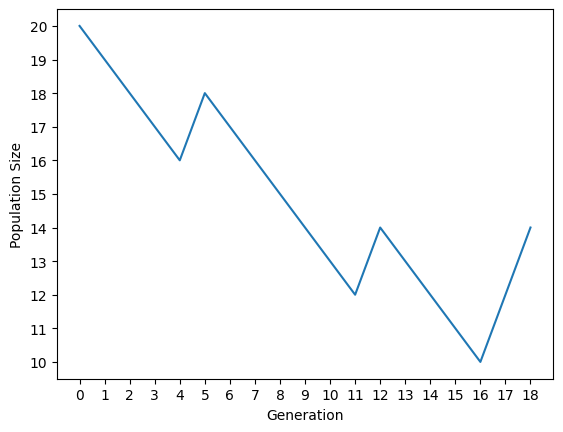

In [68]:
plt.rcdefaults()
plt.figure().clear()
plt.ylabel("Population Size")
plt.xlabel("Generation")

plt.xticks(np.arange(0, 18 + 1, 1.0))
plt.yticks(np.arange(min(pop_sizes), max(pop_sizes) + 1, 1))

plt.plot(pop_sizes)

plt.savefig("pop-size-gen.png")

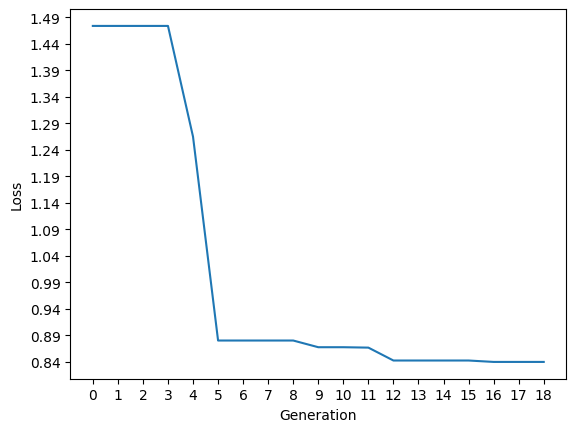

In [52]:
plt.rcdefaults()
plt.figure().clear()
plt.ylabel("Loss")
plt.xlabel("Generation")

plt.xticks(np.arange(0, 18 + 1, 1.0))
plt.yticks(np.arange(min(best_loss_in_gen), max(best_loss_in_gen) + 1, 0.05))

plt.plot(best_loss_in_gen)

plt.savefig("loss-gen.png")

<Figure size 640x480 with 0 Axes>

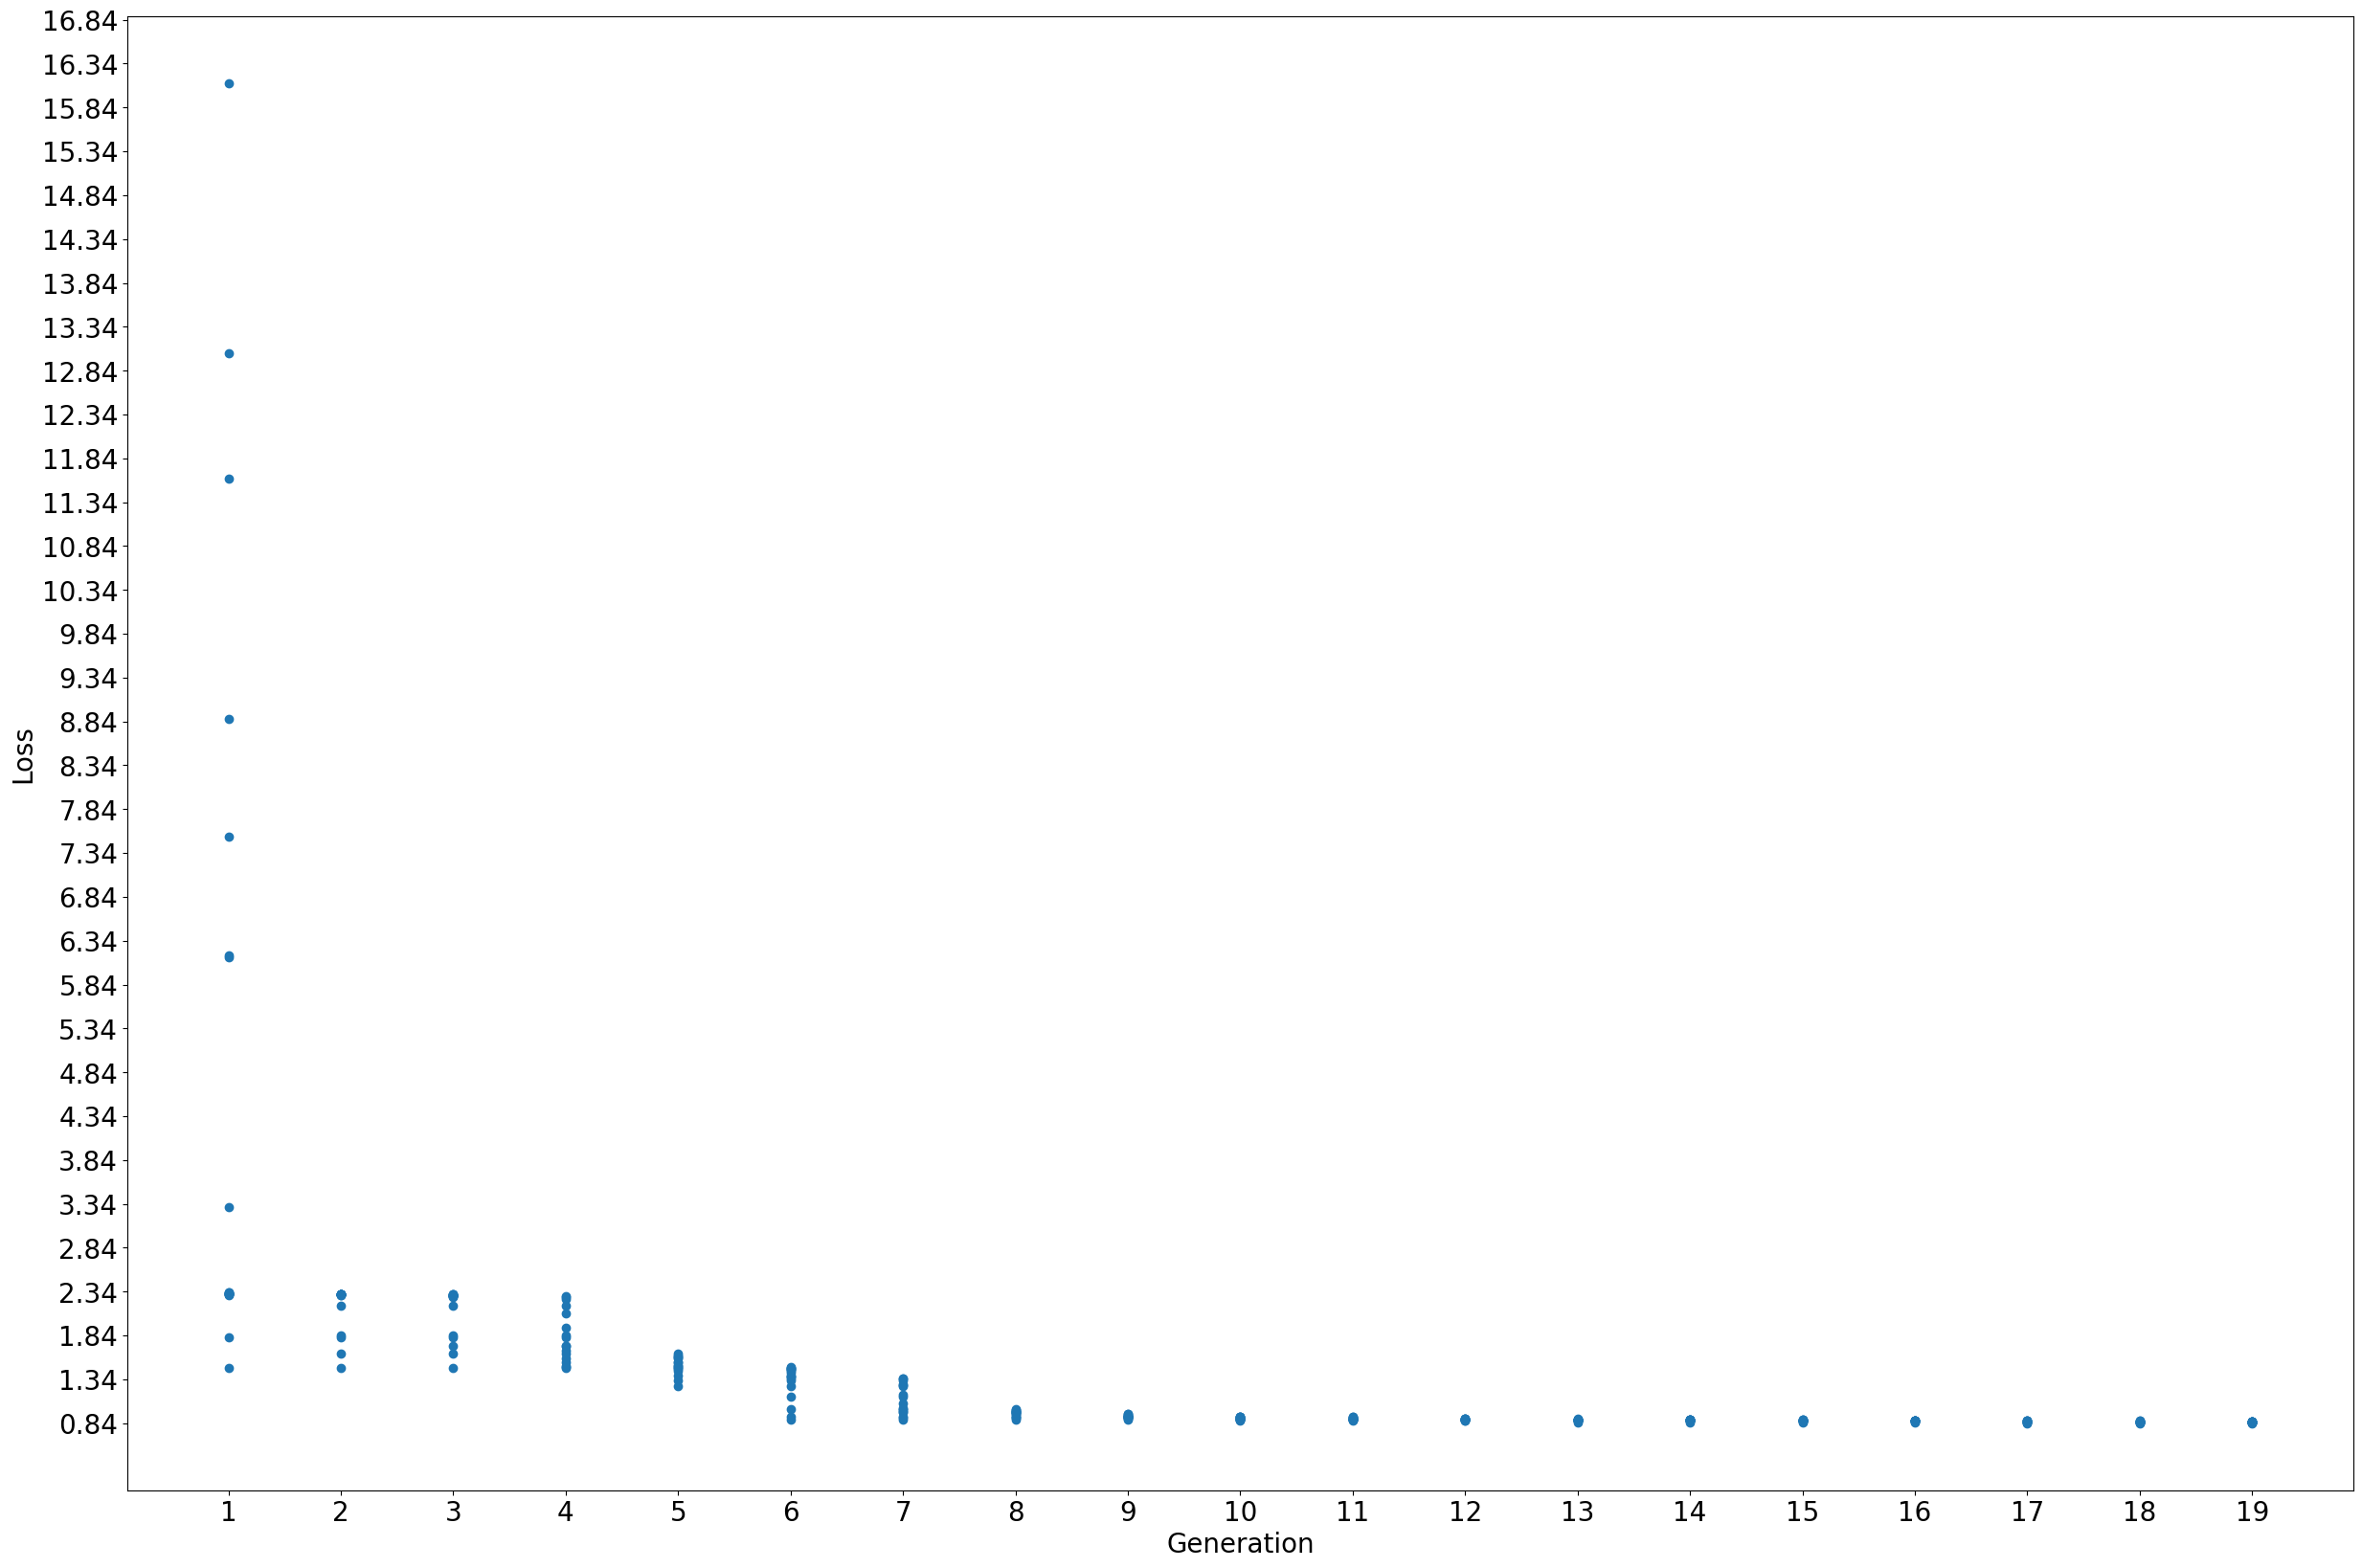

In [57]:
#plt.rcdefaults()
plt.figure().clear()
plt.figure(figsize=(30, 20))
plt.ylabel("Loss")
plt.xlabel("Generation")
x = []
y = []
ctr = 0
for g in losses_in_gen:
    ctr += 1
    for l in g:
        y.append(l)
        x.append(ctr)
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.yticks(np.arange(min(y), max(y) + 1, 0.5))
plt.rcParams.update({'font.size': 15})
plt.scatter(x, y)

plt.savefig("all-loss-gen.png")